In [1]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
dataset = pd.read_csv('updated_dataset.csv')

In [3]:
X = dataset.drop(columns=['fault'])

In [5]:
y = dataset['fault']

In [6]:
c = len(y.unique())
n = len(y)
m = X.shape[1]

In [13]:
import numpy as np

# Number of classes
classes = np.unique(y)
c = len(classes)

# Number of features
m = X.shape[1]

# Initialize within-class scatter matrix and between-class scatter matrix
Sw = np.zeros((m, m))
Sb = np.zeros((m, m))

# Compute class means
class_means = np.array([np.mean(X[y == c], axis=0) for c in classes])
overall_mean = np.mean(X, axis=0)

# Compute within-class scatter matrix
for i in classes:
    class_data = X[y == i]
    class_mean = class_means[i]
    diff = class_data - class_mean
    Sw += np.dot(diff.T, diff)

# Compute between-class scatter matrix
for i in classes:
    class_mean = class_means[i]
    diff = class_mean - overall_mean
    Sb += len(X[y == i]) * np.outer(diff, diff)

In [14]:
# Perform pairwise FDA
fault_dirs = []

for i in range(1,c):

  Sb_0 = len(X[y == 0]) * np.outer(class_means[0] - overall_mean, class_means[0] - overall_mean)
  Sb_i = len(X[y == i]) * np.outer(class_means[i] - overall_mean, class_means[i] - overall_mean)
  Sb_pair = Sb_0 + Sb_i

  Sw_0 = np.dot((X[y==0]-class_means[0]).T, X[y==0]-class_means[0])
  Sw_i = np.dot((X[y==i]-class_means[i]).T, X[y==i]-class_means[i])
  Sw_pair = Sw_0 + Sw_i

  # Compute the total scatter matrix
  St = Sw_pair + Sb_pair

  # Compute the eigenvalues and eigenvectors of (Sw^-1)*Sb
  eigen_values, eigen_vectors = np.linalg.eigh(np.linalg.inv(Sw_pair).dot(Sb_pair))

  # Sort eigenvalues and eigenvectors in descending order
  idx = eigen_values.argsort()[::-1]
  eigen_values = eigen_values[idx]
  eigen_vectors = eigen_vectors[:, idx]

  # Choose the top n_components eigenvectors
  n_components = 1
  lda_projection = eigen_vectors[:, :n_components]

  # Project data onto the LDA space
  X_lda = X.dot(lda_projection)

  # Fit the LDA model using the projected data
  lda = LinearDiscriminantAnalysis(n_components=1)
  lda.fit(X_lda,y)

  fault_dir = lda.scalings_[0]
  fault_dirs.append(fault_dir)
fault_dirs

[array([2.45399484]),
 array([2.45235137]),
 array([2.57930563]),
 array([2.57368029]),
 array([2.45235451]),
 array([2.58141973]),
 array([2.57324723]),
 array([2.46994847]),
 array([2.57134252])]

In [15]:
# Calculate variable weights
weights = []
for fault_dir in fault_dirs:
    gamma = 0.7 # adjustable parameter
    w = (fault_dir)*gamma / sum((fault_dir)*gamma)
    weights.append(w)

In [17]:
# Perform VWFDA
vwfda = LinearDiscriminantAnalysis()
X_weighted = []
for i in range(1,c):
    Xi_weighted = X[y==i] * weights[i-1][0]
    X_weighted.append(Xi_weighted)
X_prefinal = pd.concat([X[y==0], *X_weighted])
X_transformed = vwfda.fit_transform(X_prefinal,y)
print(X.shape)
print(X_transformed.shape)
# print(X_transformed)

column_names = ["max", "min", "mean", "sd", "rms", "skewness", "kurtosis", "crest", "form"]
df_vwfda = pd.DataFrame(data=X_transformed, columns=column_names)
df_vwfda.to_csv('X_transformed.csv', index=False)

(2300, 9)
(2300, 9)


In [18]:
print(y)

0       1
1       1
2       1
3       1
4       1
       ..
2295    0
2296    0
2297    0
2298    0
2299    0
Name: fault, Length: 2300, dtype: int64


In [19]:
import sklearn
from sklearn.manifold import TSNE
# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

In [20]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df_vwfda)

In [21]:
df_tsne = pd.DataFrame(data=X_tsne, columns=['Dimension 1', 'Dimension 2'])
df_tsne['Class'] = y

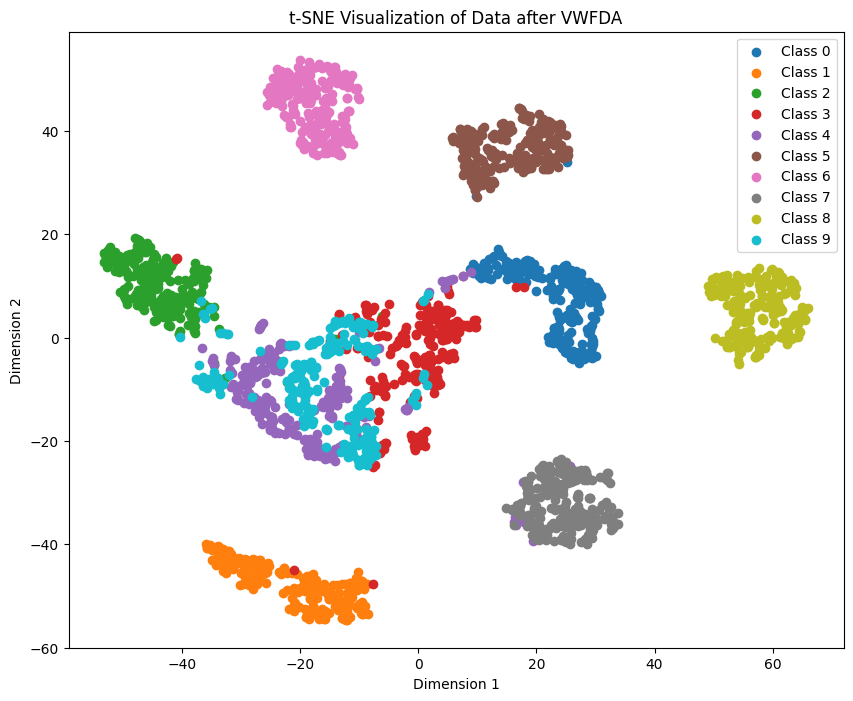

In [22]:
plt.figure(figsize=(10, 8))
for class_label in np.unique(y):
    plt.scatter(df_tsne.loc[df_tsne['Class'] == class_label, 'Dimension 1'],
                df_tsne.loc[df_tsne['Class'] == class_label, 'Dimension 2'],
                label=f'Class {class_label}')
plt.title('t-SNE Visualization of Data after VWFDA')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [23]:
X_tsne_org = tsne.fit_transform(X)
df_tsne_org = pd.DataFrame(data=X_tsne_org, columns=['Dimension 1', 'Dimension 2'])
df_tsne_org['Class'] = y

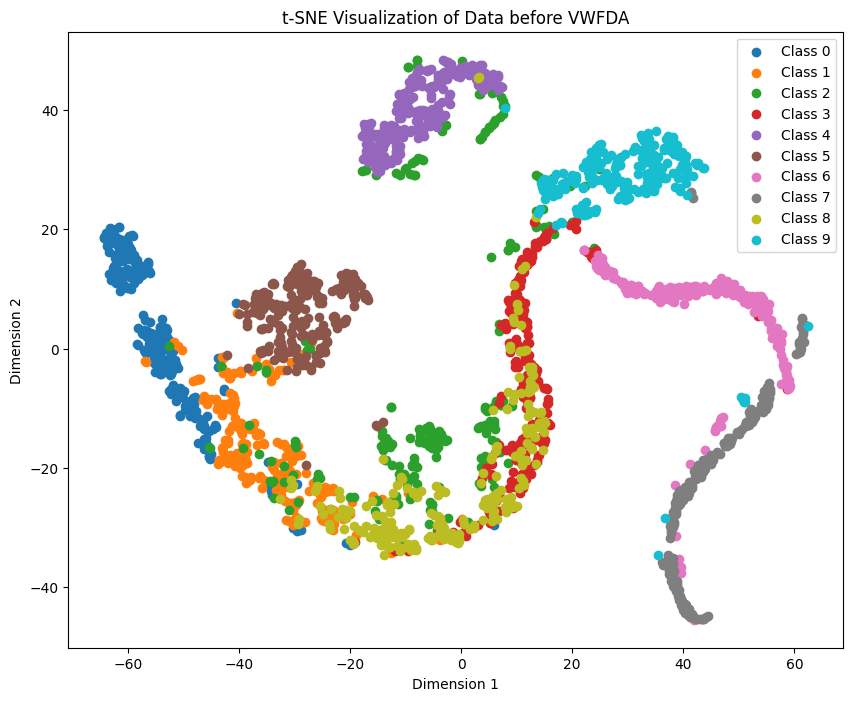

In [24]:
plt.figure(figsize=(10, 8))
for class_label in np.unique(y):
    plt.scatter(df_tsne_org.loc[df_tsne_org['Class'] == class_label, 'Dimension 1'],
                df_tsne_org.loc[df_tsne_org['Class'] == class_label, 'Dimension 2'],
                label=f'Class {class_label}')
plt.title('t-SNE Visualization of Data before VWFDA')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [25]:
avg_units_per_class = []
for class_label in np.unique(y):
    avg_units = df_tsne[df_tsne['Class'] == class_label][['Dimension 1', 'Dimension 2']].mean(axis=0)
    avg_units_per_class.append(avg_units)

# Convert the list of averages to a numpy array
avg_units_per_class = np.array(avg_units_per_class)
avg_units_per_class

array([[ 23.136211  ,   7.358336  ],
       [-21.177864  , -47.75417   ],
       [-42.850445  ,   9.402694  ],
       [ -0.84721184,  -3.731065  ],
       [-18.521988  , -11.463022  ],
       [ 15.545817  ,  36.619102  ],
       [-17.421051  ,  44.78826   ],
       [ 24.704361  , -32.365154  ],
       [ 57.391228  ,   5.289009  ],
       [-16.800383  ,  -9.387382  ]], dtype=float32)

In [26]:
def one_hot_encoding(targets, n_classes):
    return np.eye(n_classes)[targets] # one-hot encoding

In [27]:
def revert_one_hot_encoding(y):
    return np.argmax(y, axis=1) # axis=1 means that we want to find the index of the maximum value in each row

In [28]:
def split_data(X, y, test_size):

    indices = np.arange(X.shape[0]) # arange the indices
    np.random.shuffle(indices) # shuffle the indices

    X = X[indices] # assign the shuffled X
    y = y[indices] # assign the shuffled y

    n_test = int(test_size * X.shape[0]) # calculate the number of test samples

    return X[:-n_test], X[-n_test:], y[:-n_test], y[-n_test:] # return the train and test data

In [29]:
def feature_normalize(X):

    mu = np.mean(X, axis=0) # Mean of each feature
    sigma = np.std(X, axis=0) # Standard deviation of each feature

    X_norm = (X-mu)/sigma # Normalized data (zero mean and unite standard deviation)

    return X_norm, mu, sigma

In [30]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred) # mean of the elements that are equal

In [31]:
def confusion_matrix(y_true, y_pred):

    cm = np.zeros((n_classes, n_classes)) # initialize the confusion matrix

    for i in range(len(y_true)): # for each sample
        cm[y_true[i], y_pred[i]] += 1 # add 1 to the corresponding row and column

    return cm

In [32]:
def elm_train(X, y, L, w1=None):

    M = np.size(X, axis=0) # Number of examples
    N = np.size(X, axis=1) # Number of features

    # If w1 is not defined
    if w1 is None:
        #w1 = np.random.rand(L, N+1);  # Weights with bias
        w1 = np.random.uniform(low=-1, high=1, size=(L, N+1)) # Weights with bias

    bias = np.ones(M).reshape(-1, 1) # Bias definition
    #bias.shape = (M, 1)
    Xa = np.concatenate((bias, X), axis=1) # Input with bias

    S = Xa.dot(w1.T) # Weighted sum of hidden layer
    H = np.tanh(S) # Activation function f(x) = tanh(x), dimension M X L

    bias = np.ones(M).reshape(-1, 1) # Bias definition
    #bias.shape = (M, 1)
    Ha = np.concatenate((bias, H), axis=1) # Activation function with bias

    w2 = (np.linalg.pinv(Ha).dot(y)).T # w2' = pinv(Ha)*D

    y_pred = Ha.dot(w2.T) # Predictions

    return y_pred, w1, w2

In [33]:
def elm_test(X, w1, w2):

    M = np.size(X, axis=0) # Number of examples
    N = np.size(X, axis=1) # Number of features

    bias = np.ones(M).reshape(-1, 1) # Bias definition
    #bias.shape = (M, 1)
    Xa = np.concatenate((bias, X), axis=1) # Input with bias

    S = Xa.dot(w1.T) # Weighted sum of hidden layer
    H = np.tanh(S) # Activation function f(x) = tanh(x), dimension M X L

    bias = np.ones(M).reshape(-1, 1) # Bias definition
    #bias.shape = (M, 1)
    Ha = np.concatenate((bias, H), axis=1) # Activation function with bias

    y_pred = Ha.dot(w2.T) # Predictions

    return y_pred

In [34]:
n_classes = len(np.unique(y)) # Number of classes

y_encode = one_hot_encoding(y, n_classes) # One-hot encoding

print(y_encode)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [37]:
X_encode = df_vwfda.values
X_encode.shape

(2300, 9)

In [38]:
X_train, X_test, y_train, y_test = split_data(X_encode, y_encode, 0.2)

print('Train data shape:', X_train.shape)
print('Teste data shape:', X_test.shape)

Train data shape: (1840, 9)
Teste data shape: (460, 9)


In [39]:
X_train, mu, sigma = feature_normalize(X_train) # Normalize features

X_test = (X_test-mu)/sigma # Normalized data (zero mean and unite standard deviation)

print('Train mean:', np.mean(X_train, axis=0))
print('Train std:', np.std(X_train, axis=0))
print('Test mean:', np.mean(X_test, axis=0))
print('Test std:', np.std(X_test, axis=0))

Train mean: [-4.33228332e-17 -6.66586351e-17 -1.70153746e-17  1.79204477e-17
  2.80270976e-17 -3.25826322e-17  1.20676416e-19  1.87048444e-17
 -6.39585003e-18]
Train std: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test mean: [ 0.03251406  0.04447522 -0.04460203 -0.05277513 -0.07027023  0.05457581
  0.07036856  0.00293507 -0.02566301]
Test std: [0.98944734 0.99609673 0.96619754 1.03666793 0.98607071 0.90325159
 0.89340693 1.46567121 0.89988618]


In [40]:
L = 15 # Number of hidden neurons

print('Number of hidden neuros:', L)

y_train_pred, w1, w2 = elm_train(X_train, y_train, L=L) # Train
y_test_pred = elm_test(X_test, w1, w2) # Test

Number of hidden neuros: 15


In [41]:
train_acc = accuracy(revert_one_hot_encoding(y_train), revert_one_hot_encoding(y_train_pred))
test_acc = accuracy(revert_one_hot_encoding(y_test), revert_one_hot_encoding(y_test_pred))

print('Training accuracy (%):', train_acc*100)
print('Testing accuracy (%):', test_acc*100)

Training accuracy (%): 81.19565217391305
Testing accuracy (%): 78.26086956521739


In [44]:
cm = confusion_matrix(revert_one_hot_encoding(y_test), revert_one_hot_encoding(y_test_pred))

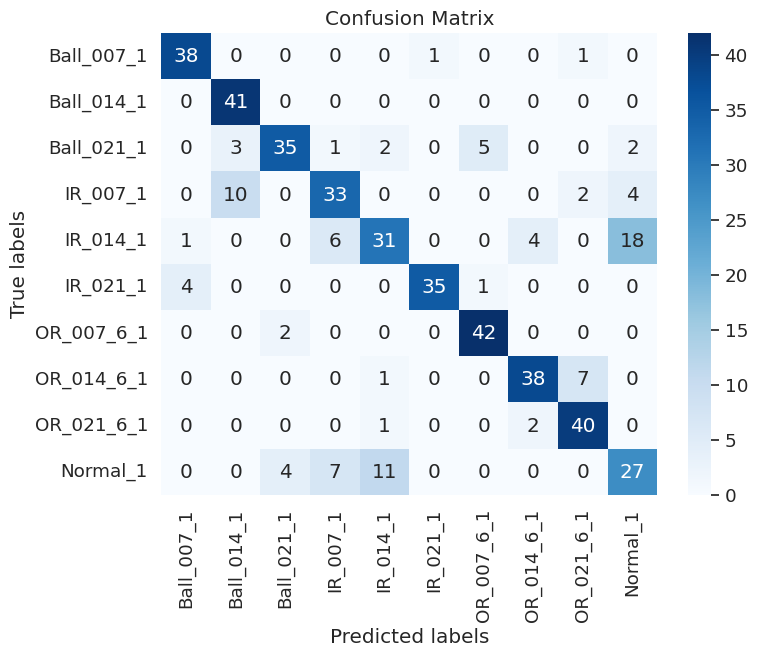

In [45]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Ball_007_1', 'Ball_014_1', 'Ball_021_1', 'IR_007_1', 'IR_014_1', 'IR_021_1', 'OR_007_6_1', 'OR_014_6_1', 'OR_021_6_1','Normal_1'],
            yticklabels=['Ball_007_1', 'Ball_014_1', 'Ball_021_1', 'IR_007_1', 'IR_014_1', 'IR_021_1', 'OR_007_6_1', 'OR_014_6_1', 'OR_021_6_1','Normal_1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()